### Creating Spark session
Spark session is "the gateway to the structured data processing".
It can be used to create datasets, dataframes, user defined functions and execute SQL.
It replaces SQLContext used in previous versions of Apache Spark.

In [1]:
import sagemaker_pyspark
from pyspark.sql import SparkSession

# This enables s3 support in Spark. You may need to restart the kernel!
classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder \
    .master("local") \
    .appName("Teemuko mle") \
    .config("spark.driver.extraClassPath", classpath) \
    .getOrCreate()

### Loading the CSV-data from S3

In [27]:
#filePath = "s3a://mle7-data/train_numeric.csv"
filePath = "s3a://sagemaker-tmukoo/ratings-5000.csv"
#filePath = "s3a://sagemaker-tmukoo/ratings.csv"


ratings = spark.read.load(filePath, format="csv", inferSchema="true", header="true")
#df=spark.read.csv(filePath,header=True)

In [22]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [14]:

ratings.describe().show()

+-------+-----------------+------------------+------------------+--------------------+
|summary|           userId|           movieId|            rating|           timestamp|
+-------+-----------------+------------------+------------------+--------------------+
|  count|         26024289|          26024289|          26024289|            26024289|
|   mean| 135037.090248114|15849.109677040553|3.5280903543608817|1.1712584326913223E9|
| stddev|78176.19722170963|31085.257531391508|1.0654427636662405|2.0528887028185263E8|
|    min|                1|                 1|               0.5|           789652004|
|    max|           270896|            176275|               5.0|          1501829870|
+-------+-----------------+------------------+------------------+--------------------+



In [15]:
# How many distinct userIds?
ratings.select('userId').distinct().count()

270896

In [16]:
# How many distinct movieIds?
ratings.select('movieId').distinct().count()

45115

In [140]:
# Most mean rating per movie and rating counts
average_ratings=ratings.groupBy(ratings.movieId).agg({"movieId": "count", "rating": "avg"}).orderBy(["count(movieId)"],ascending=0)
average_ratings.show()

+-------+------------------+--------------+
|movieId|       avg(rating)|count(movieId)|
+-------+------------------+--------------+
|   2571| 4.023809523809524|            21|
|    296| 4.368421052631579|            19|
|    318| 4.315789473684211|            19|
|    260| 4.166666666666667|            18|
|   1198| 4.088235294117647|            17|
|   2959|             3.875|            16|
|    593|           4.28125|            16|
|   1196| 4.066666666666666|            15|
|   1270| 3.966666666666667|            15|
|      1| 4.066666666666666|            15|
|    356|3.6333333333333333|            15|
|   4993|              4.25|            14|
|   1210| 4.107142857142857|            14|
|    858| 4.615384615384615|            13|
|    527| 4.269230769230769|            13|
|   1197| 4.115384615384615|            13|
|    588| 4.083333333333333|            12|
|    480|             3.875|            12|
|   1265|               4.0|            12|
|    457|3.7083333333333335|    

In [17]:
from pyspark.sql.functions import mean, min, max
ratings.select([mean('rating'), min('rating'), max('rating')]).show()

+------------------+-----------+-----------+
|       avg(rating)|min(rating)|max(rating)|
+------------------+-----------+-----------+
|3.5280903543608817|        0.5|        5.0|
+------------------+-----------+-----------+



In [18]:
ratings.take(3)

[Row(userId=1, movieId=110, rating=1.0, timestamp=1425941529),
 Row(userId=1, movieId=147, rating=4.5, timestamp=1425942435),
 Row(userId=1, movieId=858, rating=5.0, timestamp=1425941523)]

In [151]:
ratings_pivot=ratings.groupBy('userId')\
.pivot('movieId')\
.agg({"rating": "avg"})

In [166]:
ratings_pivot.select('858').show()

+----+
| 858|
+----+
|null|
| 3.0|
| 4.5|
| 5.0|
|null|
|null|
| 4.0|
|null|
| 5.0|
| 5.0|
|null|
|null|
|null|
| 4.0|
| 4.5|
|null|
|null|
| 5.0|
|null|
|null|
+----+
only showing top 20 rows



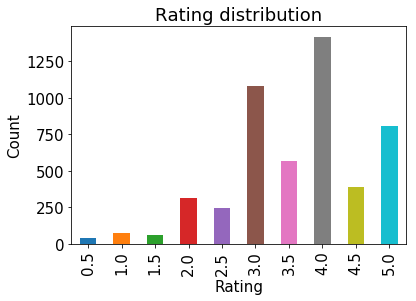

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font",size=15)
ratings.select('rating').toPandas().rating.sort_values().value_counts(sort=False).plot(kind='bar')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Machine learning to the rescue!
Note! SparkML will eventually replace MLlib. => don't use MLlib.

Example. ALS based CF: https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html

In [19]:
# DON'T! from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

#lines = spark.read.text("data/mllib/als/sample_movielens_ratings.txt").rdd
#parts = lines.map(lambda row: row.value.split("::"))
#ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]), rating=float(p[2]), timestamp=long(p[3])))
#ratings = spark.createDataFrame(ratingsRDD)

(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

Root-mean-square error = 0.8436827455622163


In [ ]:
userRecs.take(3)

In [ ]:
movieRecs.take(3)

In [62]:
# Pearson correlation test
# Result... nulls are counted as zeros in Spark => crap results
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]

data = [(Vectors.dense([7,6,7,4,5,4]),),
        (Vectors.sparse(6, [(0,6), (1,7), (3,4), (4,3), (5,4) ]),),
        (Vectors.sparse(6, [(1,3),(2,3),(3,1),(4,1)]),),
        (Vectors.dense([1,2,2,3,3,4]),),
        (Vectors.sparse(6, [(0,1),(2,1),(3,2),(4,3),(5,3)]),),
        (Vectors.sparse(6, [(0,5),(1,4),(3,3),(5,4)]),)]

df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.84034307,  0.21809502,  0.87118712,  0.33952193,
               0.64952824],
             [ 0.84034307,  1.        ,  0.21521103,  0.70676177,  0.21997067,
               0.30621273],
             [ 0.21809502,  0.21521103,  1.        ,  0.14043594,  0.6240288 ,
              -0.10247663],
             [ 0.87118712,  0.70676177,  0.14043594,  1.        ,  0.53441734,
               0.87208494],
             [ 0.33952193,  0.21997067,  0.6240288 ,  0.53441734,  1.        ,
               0.38996632],
             [ 0.64952824,  0.30621273, -0.10247663,  0.87208494,  0.38996632,
               1.        ]])
Spearman correlation matrix:
DenseMatrix([[ 1.        ,  0.75370235, -0.08823529,  0.94040326,  0.52363494,
               0.77174363],
             [ 0.75370235,  1.        , -0.14494276,  0.76503685,  0.15179419,
               0.54089872],
             [-0.08823529, -0.14494276,  1.        , -0.11941629,  0.49283288,
       

import pandas as pd
spark.createDataFrame(data).toPandas()

In [78]:
# count mean ratings


AttributeError: 'list' object has no attribute 'head'

pearsonCorr = Correlation.corr(df, "features").collect()[0][0]
print(str(pearsonCorr).replace('nan', 'NaN'))

#import numpy as np
#np.average((Vectors.sparse(4, [(0, 2.0), (3, 2.0)]),))
#neo=spark.createDataFrame([(Vectors.sparse(4, [(0, 2.0), (3, 2.0)]),)], ["rating"])

from pyspark.sql.functions import mean, min, max
#neo.select([mean('rating'), min('rating'), max('rating')]).show()

df[0]